### comment out the code below to install required packages

In [1]:
# code to install all the packages we need
# %pip install numpy
# %pip install pandas
# %pip install yfinance
# %pip install requests
# %pip install beautifulsoup4
# %pip install scikit-learn
# %pip install TA-Lib
# %pip install joblib
# %pip install pickle-mixin
# %pip install riskfolio-lib
# %pip install matplotlib

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from ibapi.client import *
from ibapi.wrapper import *
from ibapi.contract import *
from ibapi.order import *
import ibapi

import requests
import bs4 as bs
import datetime
import time
import threading
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV  
from sklearn.model_selection import RandomizedSearchCV

import joblib
import pickle

from scipy.stats import randint, uniform

import talib as ta
from talib import MA_Type

import matplotlib.pyplot as plt


In [3]:
init_event = threading.Event() # init event
id_event = threading.Event()
mkt_event = threading.Event()
hist_event = threading.Event()
order_event = threading.Event()
evec_event = threading.Event()
port_event = threading.Event()
value_event = threading.Event()

In [4]:
# define the App class
class App(EClient, EWrapper):
    def __init__(self, address, port, cid):
        EClient.__init__(self, self)
        # # list to store data
        self.bar_dict = {}
        self.mkt_price = []
        # create a connection with IBKR
        self.connect(address, port, cid)
        self.last_portfolio = pd.DataFrame(columns=["ticker","quantity","marketPrice","marketValue","averageCost","unrealizedPNL","realizedPNL"])
        self.value = 0
        # start client
        thread = threading.Thread(target=self.run)
        thread.start()
        init_event.set()


    def nextValidId(self, orderId: int):
        # provide a new order id for each of my requests
        super().nextValidId(orderId)
        logging.debug("setting nextValidOrderId: %d", orderId)
        self.nextValidOrderId = orderId
        print("NextValidId:", orderId)
        id_event.set()

    def tickPrice(self, reqId: int, tickType: int, price: float, attrib: ibapi.common.TickAttrib):
            print("Tick Price. Ticker Id:", reqId, "tickType:", tickType, "Price:", price)
            if tickType == 9: # if tickType is Close Price
                self.mkt_price.append([reqId, price])
                mkt_event.set()

    def historicalData(self, reqId, bar):
        if reqId not in self.bar_dict.keys():
            self.bar_dict[reqId] = []
        self.bar_dict[reqId].append(vars(bar))
        
    def historicalDataEnd(self, reqId, start, end):
        print(f"end of historicalData")
        hist_event.set()


    # implement code to monitor trade status and receive confirmation of the trade
    def openOrder(self, orderId: OrderId, contract: Contract, order: Order, orderstate: OrderState):
        # openorder callback
        print(f"openOrder. orderId:{orderId}, contract:{contract}, order:{order}")
        order_event.set()

    def orderStatus(self, orderId: OrderId, status: str, filled: float, reamining: float, avgFillPrice: float,
                    permId: int, parenId: int, lastFillPrice: float, clientId: int, whyHeld:str, mktCapPrice: float):
                    # orderstatus callback
        print(f"orderStatus. orderId: {orderId}, status: {status}, filled: {filled}, remaining:{reamining}, avgFillPrice: {avgFillPrice}, permId:{permId}, parentId:{parenId}, lastFillPrice: {lastFillPrice}, clientId: {clientId}, whyHeld: {whyHeld}, mktCapPrice:{mktCapPrice}")

    def execDetails(self, reqId: int, contract: Contract, execution: Execution):
        print(f"execDetails. reqId: {reqId}, contract: {contract}, execution: {execution}")
        evec_event.set()
    # basically a summary

    def commissionReport(self, commissionReport: CommissionReport):
        super().commissionReport(commissionReport)
        print("CommissionReport.", commissionReport)
        
    # called when query portfolio information
    def updatePortfolio(self, contract, position, marketPrice, marketValue, averageCost, unrealizedPNL, realizedPNL, accountName):
        self.last_portfolio = pd.concat([self.last_portfolio,
                                        pd.DataFrame([[contract.symbol, position, marketPrice, marketValue, averageCost, unrealizedPNL, realizedPNL]],
                                                    columns=self.last_portfolio.columns)],
                                        ignore_index=True)
        port_event.set()

    # query total value
    def accountSummary(self, reqId: int, account: str, tag: str, value: str, currency: str):
        self.value = float(value)
        print("Total value of the account: ", self.value)
    
    def accountSummaryEnd(self, reqId: int):
        print('end of account summary')
        value_event.set()

In [5]:
# Connect to the TWS API
app = App('127.0.0.1', 7497, 1000)
init_event.wait() # wait until it's connected
init_event.clear()

ERROR -1 502 Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002


In [6]:
app.reqMarketDataType(1) # in case it doesn't work, change 1 to 3

ERROR -1 504 Not connected


In [7]:
#get S&P tickers list from wikipedia
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

tickers = []

for row in table.findAll('tr')[1:]:
    ticker_name = row.findAll('td')[0].text
    tickers.append(ticker_name)

#clean list
tickers = [s.replace('\n', '') for s in tickers]

#get data from yfin
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now().strftime("%Y-%m-%d")
data = yf.download(tickers, start=start, end=end)

print(data)
#TODO: note we might also need to get data from tws.

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted
                            Adj Close                                     \
                                    A        AAL         AAP        AAPL   
Date                                                                       
2010-01-04 00:00:00-05:00   20.301363   4.496876   37.163254    6.505280   
2010-01-05 00:00:00-05:00   20.080832   5.005958   36.942375    6.516528   
2010-01-06 00:00:00-05:00   20.009491   4.798554   37.264507    6.412873   
2010-01-07 00:00:00-05:00   19.983541   4.939965   37.255295    6.401018   
2010-01-08 00:00:00-05:00   19.977058   4.845691   37.402546    6.443574   
...                               ...        ...         ...         ...   
2023-03-10 00:00:00-05:00  135.720001  15.460000  128.039993  148.500000   
2023-03-13 00:00:00-04:00  13

In [8]:
data.to_pickle('SP500_data.pkl')

In [9]:
# data = pd.read_pickle('SP500_data.pkl')

# data cleaning part

In [10]:
#clean data
df = data.stack().reset_index().rename(index=str, columns={"level_1": "Symbol"}).sort_values(['Symbol','Date'])
df.set_index('Date', inplace=True)

#drop tickers not in the list
tickers.remove("BRK.B")
tickers.remove("BF.B")
tickers.remove("FTV")
tickers.remove("GEHC")

#sort by group
groups = df.groupby("Symbol")
Ticker_Data = {}

for t in tickers:
    Ticker_Data[t] = groups.get_group(t)

In [11]:
df

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04 00:00:00-05:00,A,20.301363,22.389128,22.625179,22.267525,22.453505,3815561.0
2010-01-05 00:00:00-05:00,A,20.080832,22.145924,22.331903,22.002861,22.324751,4186031.0
2010-01-06 00:00:00-05:00,A,20.009491,22.067240,22.174536,22.002861,22.067240,3243779.0
2010-01-07 00:00:00-05:00,A,19.983541,22.038628,22.045780,21.816881,22.017166,3095172.0
2010-01-08 00:00:00-05:00,A,19.977058,22.031473,22.067240,21.745352,21.917025,3733918.0
...,...,...,...,...,...,...,...
2023-03-10 00:00:00-05:00,ZTS,161.529999,161.529999,163.360001,160.070007,163.000000,3326400.0
2023-03-13 00:00:00-04:00,ZTS,163.410004,163.410004,164.889999,159.850006,161.990005,2772100.0
2023-03-14 00:00:00-04:00,ZTS,164.559998,164.559998,166.860001,162.470001,165.960007,1911300.0


In [ ]:

# for t in tickers:
#     Ticker_Data[t].loc[:,'High Shifted']=Ticker_Data[t]['High'].shift(1)
#     Ticker_Data[t].loc[:,'Low Shifted'] = Ticker_Data[t]['Low'].shift(1)
#     Ticker_Data[t].loc[:,'Close Shifted'] = Ticker_Data[t]['Close'].shift(1)
    
#     Ticker_Data[t].loc[:,'Upper BBand'], Ticker_Data[t].loc[:,'Middle BBand'],Ticker_Data[t].loc[:,'Lower BBand']= ta.BBANDS(Ticker_Data[t]['Close Shifted'],
#                                                                                                        timeperiod=20)

#     Ticker_Data[t].loc[:,'Macd'], Ticker_Data[t].loc[:,'Macd Signal'],Ticker_Data[t].loc[:,'Macd Hist'] = ta.MACD(Ticker_Data[t]['Close Shifted'], fastperiod=12, slowperiod=26, 
#                                                                signalperiod=9)
#     Ticker_Data[t].loc[:,'Momentum'] = ta.MOM(Ticker_Data[t]['Close Shifted'],timeperiod=10)
    
#     Ticker_Data[t].loc[:,'RSI'] = ta.RSI(np.array(Ticker_Data[t]['Close Shifted']), timeperiod=12)

#     Ticker_Data[t].loc[:,'ROC'] = ta.ROC(np.array(Ticker_Data[t]['Close Shifted']), timeperiod=10)

#     Ticker_Data[t].loc[:,'Returns'] = np.log(Ticker_Data[t]['Open'].shift(-7)/Ticker_Data[t]['Open']) # I want to predict the return of 7 trading days after today.

#     Ticker_Data[t].dropna(inplace =True)

#     # get rid of the 30% data in the middle to reduce noise.
#     Ticker_Data[t]=Ticker_Data[t].sort_values(by=['Returns'])
#     Ticker_Data[t]=pd.concat([Ticker_Data[t].iloc[:int(np.floor(len(Ticker_Data[t]['Returns'])*0.35)),:],
#                             Ticker_Data[t].iloc[int(np.floor(len(Ticker_Data[t]['Returns'])*0.85)):,:]])

In [ ]:
last_X = {} # use the last day's data to make prediction

for t in tickers:
    Ticker_Data[t].loc[:,'High Shifted']=Ticker_Data[t]['High'].shift(1)
    Ticker_Data[t].loc[:,'Low Shifted'] = Ticker_Data[t]['Low'].shift(1)
    Ticker_Data[t].loc[:,'Close Shifted'] = Ticker_Data[t]['Close'].shift(1)
    
    Ticker_Data[t].loc[:,'Upper BBand'], Ticker_Data[t].loc[:,'Middle BBand'],Ticker_Data[t].loc[:,'Lower BBand']= ta.BBANDS(Ticker_Data[t]['Close Shifted'],
                                                                                                       timeperiod=20)

    Ticker_Data[t].loc[:,'Macd'], Ticker_Data[t].loc[:,'Macd Signal'],Ticker_Data[t].loc[:,'Macd Hist'] = ta.MACD(Ticker_Data[t]['Close Shifted'], fastperiod=12, slowperiod=26, 
                                                               signalperiod=9)
    Ticker_Data[t].loc[:,'Momentum'] = ta.MOM(Ticker_Data[t]['Close Shifted'],timeperiod=10)
    
    Ticker_Data[t].loc[:,'RSI'] = ta.RSI(np.array(Ticker_Data[t]['Close Shifted']), timeperiod=12)

    Ticker_Data[t].loc[:,'ROC'] = ta.ROC(np.array(Ticker_Data[t]['Close Shifted']), timeperiod=10)

    Ticker_Data[t].loc[:,'Returns'] = np.log(Ticker_Data[t]['Open'].shift(-7)/Ticker_Data[t]['Open']) # I want to predict the return of 7 trading days after today.

    last_X[t] = Ticker_Data[t].iloc[-1,:].drop(['Returns', 'Symbol', 'High Shifted', 'Low Shifted', 'Close Shifted'])

    Ticker_Data[t].dropna(inplace =True)

    # get rid of the 30% data in the middle to reduce noise.
    Ticker_Data[t]=Ticker_Data[t].sort_values(by=['Returns'])
    Ticker_Data[t]=pd.concat([Ticker_Data[t].iloc[:int(np.floor(len(Ticker_Data[t]['Returns'])*0.35)),:],
                            Ticker_Data[t].iloc[int(np.floor(len(Ticker_Data[t]['Returns'])*0.85)):,:]])

# stock selection

In [13]:
X = []
Y = []

for i in tickers:
    X.append(Ticker_Data[i].drop(columns=['Symbol','Returns', 'High Shifted', 'Low Shifted', 'Close Shifted']))
    Y.append(Ticker_Data[i]['Returns'].apply(lambda x:1 if (x>np.mean(Ticker_Data[i]['Returns']) and (x>0)) else -1)) # 1 or -1
# turn list into dataframe
X = pd.concat(X)
Y = pd.concat(Y)

In [14]:
# SVM pipeline
# only need to excute it once if it takes too long
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# define the hyperparameter search space
# define the hyperparameter search space
param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(3, 25),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 6),
    'classifier__max_features': ['sqrt', 'log2'],
}
# define the search parameters
n_iter_search = 10  # number of parameter combinations to try
cv = 5  # number of cross-validation folds

# randomsearch
clf = RandomizedSearchCV(pipe, param_dist, n_iter=n_iter_search, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
clf.fit(X, Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=6, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=7, classifier__n_estimators=373; total time=14.9min
[CV] END classifier__max_depth=6, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=7, classifier__n_estimators=373; total time=15.0min
[CV] END classifier__max_depth=6, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=7, classifier__n_estimators=373; total time=15.1min
[CV] END classifier__max_depth=16, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=242; total time=19.8min
[CV] END classifier__max_depth=16, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=242; total time=19.9min
[CV] END classifier__max_depth=16, classif

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faa6e025cf0>,
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faa6e027f10>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faa6e025fc0>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faa2094a650>},
                   scoring='f1', verbose=2)

In [15]:
print(clf.cv_results_)
print('--------------------')
print(clf.scorer_)
print('--------------------')
print(clf.best_score_)
print('--------------------')
print(clf.best_params_)

{'mean_fit_time': array([1197.62075419,  906.49400411, 1907.9041676 , 1051.087817  ,
       1093.52276592,  859.36138501, 1014.76596427, 1503.2798739 ,
       1632.51652608,  917.61842408]), 'std_fit_time': array([  9.72758924,  16.46910725,  16.0868925 ,   9.81646082,
         4.51032134,   7.66838764,   8.47897555,   6.44535592,
       103.07769461,  77.29163991]), 'mean_score_time': array([ 7.42405853,  4.92972722, 11.6518033 ,  5.50867105,  6.87579184,
        4.99461789,  5.46688113,  9.35767627,  7.51676807,  4.38459229]), 'std_score_time': array([0.18857595, 0.34205228, 1.02511862, 0.17657909, 0.31682041,
       0.18103017, 0.14701912, 0.24615959, 1.73494685, 0.67786273]), 'param_classifier__max_depth': masked_array(data=[16, 6, 15, 11, 18, 16, 6, 17, 10, 7],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_classifier__max_features': masked_array(data=['sqrt', 'lo

In [16]:
# retrain the pipeline with the best parameters on the entire dataset
best_pipe = pipe.set_params(**clf.best_params_)
# fit it to the entire data.
best_pipe.fit(X, Y)

# save the resulting model to disk
joblib.dump(best_pipe, 'rf_model.joblib')

['rf_model.joblib']

# Feature importance based on mean decrease in impurity

In [28]:
importances

array([0.06988674, 0.05887111, 0.04978569, 0.04145766, 0.06449304,
       0.06013531, 0.05136802, 0.05403035, 0.06431609, 0.05662263,
       0.07157791, 0.06609526, 0.06074369, 0.05264311, 0.08616407,
       0.09180932])

In [30]:
importances = best_pipe[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in best_pipe[1].estimators_], axis=0)

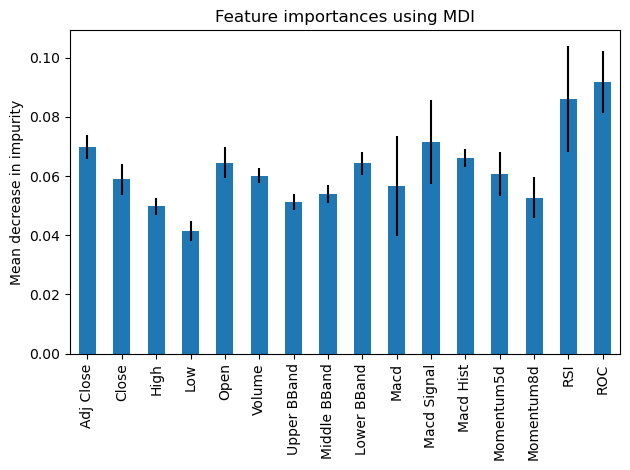

In [31]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# load model

In [ ]:
clf = joblib.load('rf_model.joblib')
# retrain the model with updated data

# select top ten stocks

In [ ]:
probs = []
for t in tickers:
    tmp_X = last_X[t].reset_index(drop=True).to_numpy().reshape(1, -1)
    last_X_df = pd.DataFrame(tmp_X, columns=last_X[t].index)
    probs.append(clf.predict_proba(last_X_df)[:,1][0]) #  how close it is to 1

# sort probabilities in descending order
sorted_probs = np.sort(probs)[::-1]

# set threshold for top ten closest to 1
threshold = sorted_probs[9]

# set top ten closest to 1 to 1, and the rest to 0
tmp_index = np.zeros(len(probs))
tmp_index[probs >= threshold] = 1
tmp_index = tmp_index.astype(int)


In [ ]:
portfolio_list = [tickers[i] for i in range(len(tmp_index)) if tmp_index[i] == 1]
portfolio_list

['LNT', 'AWK', 'CHTR', 'FRC', 'MRNA', 'OGN', 'SRE', 'UNH', 'UHS', 'WBA']

In [ ]:
with open('portfolio_list.pickle', 'wb') as f:
    pickle.dump(portfolio_list, f)

# experiment

In [ ]:
# import yfinance as yf

# # Get stock information for Apple
# apple = yf.Ticker("AAPL")

# ## Get the latest financial statement data
# financials = apple.financials 
# # Get the net income
# net_income = financials.loc['Net Income']

# # Get the latest balance sheet data
# balance_sheet = apple.balance_sheet
# # Get the total assets
# total_assets = balance_sheet.loc['Total Assets']
# total_equity = balance_sheet.loc['Total Equity Gross Minority Interest']
# #-------------------------------
# roa = net_income / total_assets
# roe = net_income / total_equity


In [ ]:
app.disconnect()